# Setup and Helper Functions

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import json
import ipywidgets as widgets

from matplotlib import pyplot as plt
from sklearn.neighbors import KDTree

sns.set_style(style="darkgrid")

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', None)

In [3]:
def multiplot_from_generator(g, num_columns):
    next(g)
    
    figsize = (15, 15/num_columns)
    
    try:
        while True:
            plt.figure(figsize=figsize)
            for col in range(num_columns):
                ax = plt.subplot(1, num_columns, col+1)
                next(g)
    except StopIteration:
        pass

In [4]:
def plot_map(data, ax=None, s=5, a=0.75, q_lo=0.0, q_hi=0.9, cmap='autumn', column='price', title='Moscow apartment price by location'):
    data = data[['latitude', 'longitude', column]].sort_values(by=column, ascending=True)
    backdrop = plt.imread('data/moscow.png')
    backdrop = np.einsum('hwc, c -> hw', backdrop, [0, 1, 0, 0]) ** 2
    if ax is None:
        plt.figure(figsize=(12, 8), dpi=100)
        ax = plt.gca()
    discrete = data[column].nunique() <= 20
    if not discrete:
        lo, hi = data[column].quantile([q_lo, q_hi])
        hue_norm = plt.Normalize(lo, hi)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(lo, hi))
        sm.set_array([])
    else:
        hue_norm = None 
    ax.imshow(backdrop, alpha=0.5, extent=[37, 38, 55.5, 56], aspect='auto', cmap='bone', norm=plt.Normalize(0.0, 2))
    sns.scatterplot(x='longitude', y='latitude', hue=data[column].tolist(), ax=ax, s=s, alpha=a, palette=cmap,linewidth=0, hue_norm=hue_norm, data=data)
    ax.set_xlim(37, 38)    # min/max longitude of image 
    ax.set_ylim(55.5, 56)  # min/max latitude of image
    if not discrete:
        ax.legend().remove()
        ax.figure.colorbar(sm)
    ax.set_title(title)
    return ax, hue_norm

In [5]:
def one_hot_encode(data, categories, orig_var, remove_org=False):
    for k, category in categories.items():
        data[category] = (data[orig_var] == k).astype(int)
    if remove_org:
        data.drop(orig_var, axis=1, inplace=True)
    return data

In [6]:
def log_transform(data, features):
    for feature in features:
        data["log_{}".format(feature)] = np.log1p(data[feature])
        return data

In [7]:
import geopy.distance

def distance_to_center_feature(data):
    moscow_center = [55.751244, 37.618423]
    coordinates = data[['latitude', 'longitude']].to_numpy()
    dist = [geopy.distance.distance(moscow_center, coordinate).km for coordinate in coordinates]
    data['distance_to_center'] = dist

In [8]:
def bathrooms_feature(data):
    data["bathrooms"] = data.bathrooms_shared + data.bathrooms_private

In [9]:
def has_seller_feature(data):
    for ind, row in data.iterrows():
        data.at[ind, "has_seller"] = pd.isna(row.seller)
    data['has_seller'] = data['has_seller'].astype(int)   

In [10]:
def distance_to_metro_feature(data):
    metro_data = pd.read_csv("data/metro_stations.csv")
    metro_data = metro_data[["latitude", "longitude"]]
    coordinate_tree = KDTree(metro_data)
    for ind, row in data.iterrows():
        apartment_coordinates = [[row["latitude"], row["longitude"]]]
        metro_coordinate_ind = coordinate_tree.query(apartment_coordinates, 1, return_distance=False)[0][0]
        metro_coordinate = metro_data.loc[[metro_coordinate_ind]].to_numpy()
        distance = geopy.distance.distance(apartment_coordinates, metro_coordinate).km
        data.at[ind, "distance_to_metro"] = distance

In [11]:
def bearing_feature(data):
    for ind, row in data.iterrows():
        moscow_center = [55.751244, 37.618423]
        c1 = moscow_center
        c2 = [row["latitude"], row["longitude"]]
        y = np.sin(c2[1] - c1[1]) * np.cos(c2[0])
        x = np.cos(c1[0]) * np.sin(c2[0]) - np.sin(c1[0]) * np.cos(c2[0]) * np.cos(c2[1] - c1[1])
        rad = np.arctan2(y, x)
        bearing = ((rad * 180 / np.pi) + 360) % 360
        data.at[ind, "bearing"] = bearing

In [12]:
def distance_to_hospital_feature(data):
    hospital_data = pd.read_csv("data/hospitals.csv")
    hospital_data = hospital_data[["latitude", "longitude"]]
    coordinate_tree = KDTree(hospital_data)
    for ind, row in data.iterrows():
        apartment_coordinates = [[row["latitude"], row["longitude"]]]
        hospital_coordinate_ind = coordinate_tree.query(apartment_coordinates, 1, return_distance=False)[0][0]
        hospital_coordinate = hospital_data.loc[[hospital_coordinate_ind]].to_numpy()
        distance = geopy.distance.distance(apartment_coordinates, hospital_coordinate).km
        data.at[ind, "distance_to_hospital"] = distance

In [13]:
def elevator_feature(data):
    for ind, row in data.iterrows():
        data.at[ind, "elevator"] = row.elevator_passenger == 1 or row.elevator_service == 1

In [14]:
def construct_features(data):
    distance_to_center_feature(data)
    bathrooms_feature(data)
    has_seller_feature(data)
    distance_to_metro_feature(data)
    bearing_feature(data)
    distance_to_hospital_feature(data)
    elevator_feature(data)
    
    return data

# Load Data

In [15]:
apartments_train = pd.read_csv('data/apartments_train.csv')
buildings_train = pd.read_csv('data/buildings_train.csv')
apartments_test = pd.read_csv('data/apartments_test.csv')
buildings_test = pd.read_csv('data/buildings_test.csv')

# load meta info
with open('data/apartments_meta.json') as f:
    apartments_meta = json.load(f)
    
with open('data/buildings_meta.json') as f:
    buildings_meta = json.load(f)

meta_info = apartments_meta + buildings_meta

Merge building and apartment data

In [16]:
train = pd.merge(
    apartments_train, 
    buildings_train.set_index('id'), 
    how='left', 
    left_on='building_id', 
    right_index=True
)
test = pd.merge(
    apartments_test, 
    buildings_test.set_index('id'), 
    how='left', 
    left_on='building_id', 
    right_index=True
)

### Missing longitude and latitude in test data
Replace the missing longitude and latitude in the testdata with the coordinates retrieved from Google Maps based on the address.

In [17]:
ind = test[test["longitude"].isna()].index
test.at[ind, "latitude"] = 55.56776345324702
test.at[ind, "longitude"] = 37.48171529826662

### Missing district values
Missing district values will be replaced by the category "Other" (12)

In [18]:
ind = train[train.district.isna()].index
train.at[ind, "district"] = 12
ind = test[test.district.isna()].index
test.at[ind, "district"] = 12

# Exploratory Data Analysis

## Meta Information

In [19]:
import json

def print_meta_info():
    
    df_data = []
    for entry in meta_info:
        nan_count_train, nan_count_test = np.NaN, np.NaN
        data_type = entry["name"]
        if data_type in train:
            nan_count_train = len(train[train[data_type].isna()])
        if data_type in test:
            nan_count_test = len(test[test[data_type].isna()])
        row = [entry["name"], entry["type"], entry["desc"], nan_count_train, nan_count_test]
        df_data.append(row)
    
    df = pd.DataFrame(df_data, columns=["name", "type", "desc", "nan_count_train", "nan_count_test"])
    return df

meta_df = print_meta_info()
meta_df

,name,type,desc,nan_count_train,nan_count_test
0,id,integer_id,Unique ID for apartment,0,0.0
1,seller,categorical,The type of apartment seller,8830,3942.0
2,price,real,The listed price of the apartment (TARGET),0,NaN
3,area_total,real,Total area of the apartment,0,0.0
4,area_kitchen,real,Total kitchen area in the apartment,4721,2233.0
5,area_living,real,Total living space area in the apartment,3882,2019.0
6,floor,integer,Primary building floor of the apartment,0,0.0
7,rooms,integer,Number of rooms in the apartment,0,0.0
8,layout,categorical,Overal apartment layout,17642,7368.0
9,ceiling,real,Ceiling height in the apartment,11093,5018.0


<AxesSubplot:title={'center':'Fraction of NaN values in the test set'}>

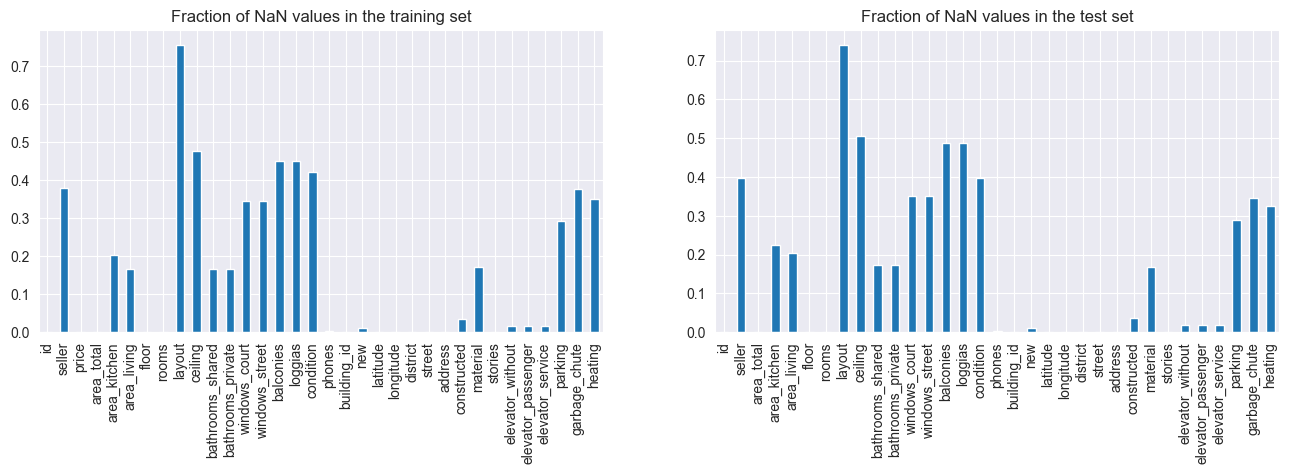

In [20]:
fig, (ax1, ax2) = plt.subplots(figsize=(16, 4), ncols=2, dpi=100)
train.isna().mean().plot.bar(ax=ax1, title='Fraction of NaN values in the training set')
test.isna().mean().plot.bar(ax=ax2, title='Fraction of NaN values in the test set')

**EDA insight:** Several features in both the training and test contain multiple NaN values. The distribution of NaN values appears to be similar in both datasets. However, the test data also has two rows with missing longitude and latitude values.

## Statistics

In [21]:
print("Number of training samples: {}".format(train.shape[0]))
print("Number of test samples: {}".format(test.shape[0]))
print("Number of features: {}".format(train.shape[1]))

Number of training samples: 23285
Number of test samples: 9937
Number of features: 34


In [22]:
print("Train data statistics")
train.describe()

Train data statistics


,id,seller,price,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,bathrooms_shared,bathrooms_private,windows_court,windows_street,balconies,loggias,condition,phones,building_id,new,latitude,longitude,district,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
count,23285.000000,14455.000000,2.328500e+04,23285.000000,18564.000000,19403.000000,23285.000000,23285.000000,5643.000000,12192.000000,19413.000000,19413.000000,15213.000000,15213.000000,12765.000000,12765.000000,13475.000000,23205.000000,23285.000000,23021.000000,23285.000000,23285.000000,23285.000000,22491.000000,19313.000000,23285.000000,22928.000000,22928.000000,22928.000000,16497.000000,14474.000000,15124.000000
mean,11642.000000,1.875683,2.355617e+07,74.450999,12.552279,38.741367,8.969594,2.189349,1.039695,3.268374,0.737547,0.662855,0.797147,0.468678,0.556365,0.673090,1.270501,1.162293,4844.089156,0.337692,55.728337,37.583425,4.695856,2002.729581,2.203956,17.608933,0.392620,0.929867,0.743109,0.572589,0.806411,0.176012
std,6721.944845,1.089518,5.264393e+07,58.671373,6.565686,31.398480,8.322039,1.076130,0.351507,10.802728,0.781173,0.716888,0.402137,0.499034,0.641257,0.664779,1.017037,0.456937,2790.676698,0.472933,0.101831,0.150181,3.194250,22.948365,1.021101,11.216638,0.488344,0.255376,0.436928,0.549630,0.395124,0.566275
min,0.000000,0.000000,9.000000e+05,9.300000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,55.211430,36.864371,0.000000,1855.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5821.000000,1.000000,7.490000e+06,42.000000,8.200000,20.000000,3.000000,1.000000,1.000000,2.650000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2426.000000,0.000000,55.664837,37.497827,2.000000,1989.000000,2.000000,9.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,11642.000000,2.000000,1.064500e+07,59.800000,10.700000,30.900000,7.000000,2.000000,1.000000,2.800000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,4772.000000,0.000000,55.738622,37.571938,5.000000,2013.000000,2.000000,16.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
75%,17463.000000,3.000000,2.050000e+07,84.800000,15.300000,45.300000,12.000000,3.000000,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,7340.000000,1.000000,55.797458,37.671085,7.000000,2020.000000,3.000000,22.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,23284.000000,3.000000,2.600000e+09,2181.000000,100.000000,900.000000,95.000000,6.000000,2.000000,340.000000,4.000000,4.000000,1.000000,1.000000,4.000000,4.000000,3.000000,2.000000,9735.000000,1.000000,56.006507,37.950668,12.000000,2023.000000,6.000000,95.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000


**EDA insight:** There is a significant difference between the 75% percentile and the maximum value for the price, area_total, area_kitchen, area_living, floor, rooms, ceiling, loggias, balconies, and stories features, suggesting the presence of outliers. These need to be handled.

In [23]:
print("Test data statistics")
test.describe()

Test data statistics


,id,seller,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,bathrooms_shared,bathrooms_private,windows_court,windows_street,balconies,loggias,condition,phones,building_id,new,latitude,longitude,district,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
count,9937.000000,5995.000000,9937.000000,7704.000000,7918.000000,9937.000000,9937.000000,2569.000000,4919.000000,8220.000000,8220.000000,6449.000000,6449.000000,5102.000000,5102.000000,5978.000000,9897.000000,9937.000000,9828.000000,9937.000000,9937.000000,9937.000000,9563.000000,8266.000000,9937.000000,9757.000000,9757.000000,9757.000000,7070.000000,6511.000000,6707.000000
mean,28253.000000,1.805838,75.144219,12.874883,39.500515,9.184160,2.202878,1.036201,3.725885,0.776642,0.611922,0.809273,0.438518,0.584673,0.632301,1.259284,1.175003,4694.767032,0.302503,55.710949,37.562863,4.674751,2002.239569,2.236632,18.107578,0.428513,0.924567,0.746438,0.556577,0.764552,0.140152
std,2868.709146,1.087742,56.359318,6.878015,33.145228,7.963073,1.107315,0.334674,15.915162,0.811608,0.709386,0.392905,0.496244,0.645422,0.669174,1.041879,0.462727,2772.449218,0.459365,0.810306,2.441198,3.173569,23.635988,1.063680,10.725279,0.494889,0.264102,0.435072,0.578640,0.424311,0.515819
min,23285.000000,0.000000,13.000000,1.200000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,17.141734,-61.790500,0.000000,1860.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25769.000000,1.000000,42.400000,8.200000,20.000000,3.000000,1.000000,1.000000,2.650000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2145.000000,0.000000,55.669772,37.492455,2.000000,1988.000000,2.000000,10.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,28253.000000,2.000000,59.600000,10.800000,31.000000,7.000000,2.000000,1.000000,2.800000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,4728.000000,0.000000,55.738449,37.568920,5.000000,2014.000000,2.000000,17.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
75%,30737.000000,3.000000,86.000000,16.000000,45.400000,13.000000,3.000000,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,6983.000000,1.000000,55.798905,37.662812,7.000000,2019.000000,3.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,33221.000000,3.000000,1175.000000,63.600000,528.000000,69.000000,6.000000,2.000000,350.000000,4.000000,4.000000,1.000000,1.000000,4.000000,4.000000,3.000000,2.000000,9734.000000,1.000000,56.001625,132.768097,12.000000,2022.000000,6.000000,87.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000


### Construct features

In [24]:
train = construct_features(train)
test = construct_features(test)

**EDA insight:** There are some latitude and longitude values in the test data indicating a location far away from moscow.

In [25]:
features = test.columns
def plot_feature_histogram():
    for feature in features:
        yield
        sns.histplot(data=test[feature])

# multiplot_from_generator(plot_feature_histogram(), 3)

In [26]:
features = train.columns[train.columns != "price"]
def plot_price_feature_relation():
    for feature in features:
        yield
        sns.scatterplot(x=feature, y="price", data=train)

# multiplot_from_generator(plot_price_feature_relation(), 3)

**EDA insight**:
1. area_total has a high correlation with the price. It would be interesting to see if the correlation increases if only houses that are close to the city center (i.e. not further than 10kms) are considered. The same applies to area_living.
2. It would be interesting to see if there are some streets where the house prices tend to be higher than in other streets (similar to monopoly).
3. For houses built after 1990, the house prices tend to increase with a lower age, whereas it is the opposite for houses built before 1990. If the house was built before 1990, the older it is, the more expensive it gets.
4. The distance certainly appears to play a role. If the houses are further away than 15kms from the city center, the prices tend to be very low. However, the variance is quite high for the houses even if they are close to the image center. The reason for this needs to be investigated. It may be due to the age of the building.
5. It would be interesting to see how the age and distance behave with respect to the price. For instance, do houses with a low distance but high age tend to be cheaper?
6. Could there be a relation between the age and the number of stories as well as the price? For example, do new buildings tend to have more floors than old buildings and if so, does this have a positive correlation with the price?
7. There is a high variability between the prices in some districts? What may be the cause of this? Can it be related to the age?
8. Do buildings that are close to each other have similar prices? E.g., if there the neighbouring building tends to be expensive, is the other building also expensive?

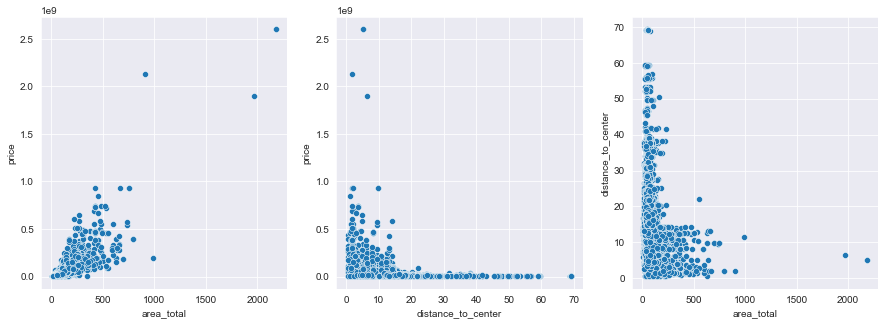

In [27]:
plt.show()
def area_total_distance_price():
    d = train
    yield
    sns.scatterplot(x="area_total", y="price", data=d)
    yield
    sns.scatterplot(x="distance_to_center", y="price", data=d)
    yield
    sns.scatterplot(x="area_total", y="distance_to_center", data=d)

multiplot_from_generator(area_total_distance_price(), num_columns=3)

**EDA insight**: Houses further away from the center have a rather low total area than those close to the center.
**EDA insight**: Considering the price per square meter could give further insight.

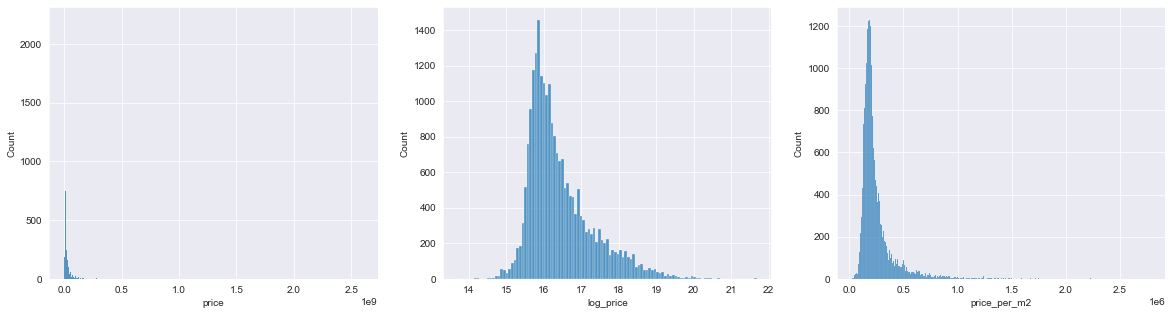

In [28]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
sns.histplot(data=train["price"], ax=ax[0])
train["log_price"] = np.log1p(train["price"])
sns.histplot(data=train["log_price"], ax=ax[1])
train["price_per_m2"] = train["price"] / train["area_total"]
sns.histplot(data=train["price_per_m2"], ax=ax[2])
plt.show()

**EDA insight:** As we can see, the unadjusted price is significantly right skewed. While computing the price per square meter looks a bit better, a log transformation of the price is even better.

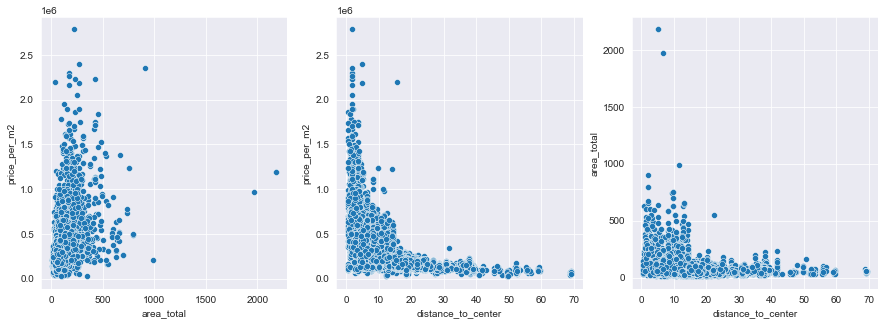

In [29]:
def area_total_distance_price_per_m2():
    d = train
    yield
    sns.scatterplot(x="area_total", y="price_per_m2", data=d)
    yield
    sns.scatterplot(x="distance_to_center", y="price_per_m2", data=d)
    yield
    sns.scatterplot(x="distance_to_center", y="area_total", data=d)

multiplot_from_generator(area_total_distance_price_per_m2(), num_columns=3)

**EDA insight:** The m2 price increases significantly with a shorter distance and indicates a clearer relationship than the price alone. However, there is still a strong variability which needs to be further investigated. What distinguishes cheap houses that are close to the center from expensive ones? Age? Number of stories? The street they are placed in? The price of other houses in the vicinity?

Possible features of interest:
* Distance to schools, shopping and entertainment opportunities, as well as recreational centers
* Proximity to public transport and highways
* neighbourhood comps, i.e., clusterings of the homes

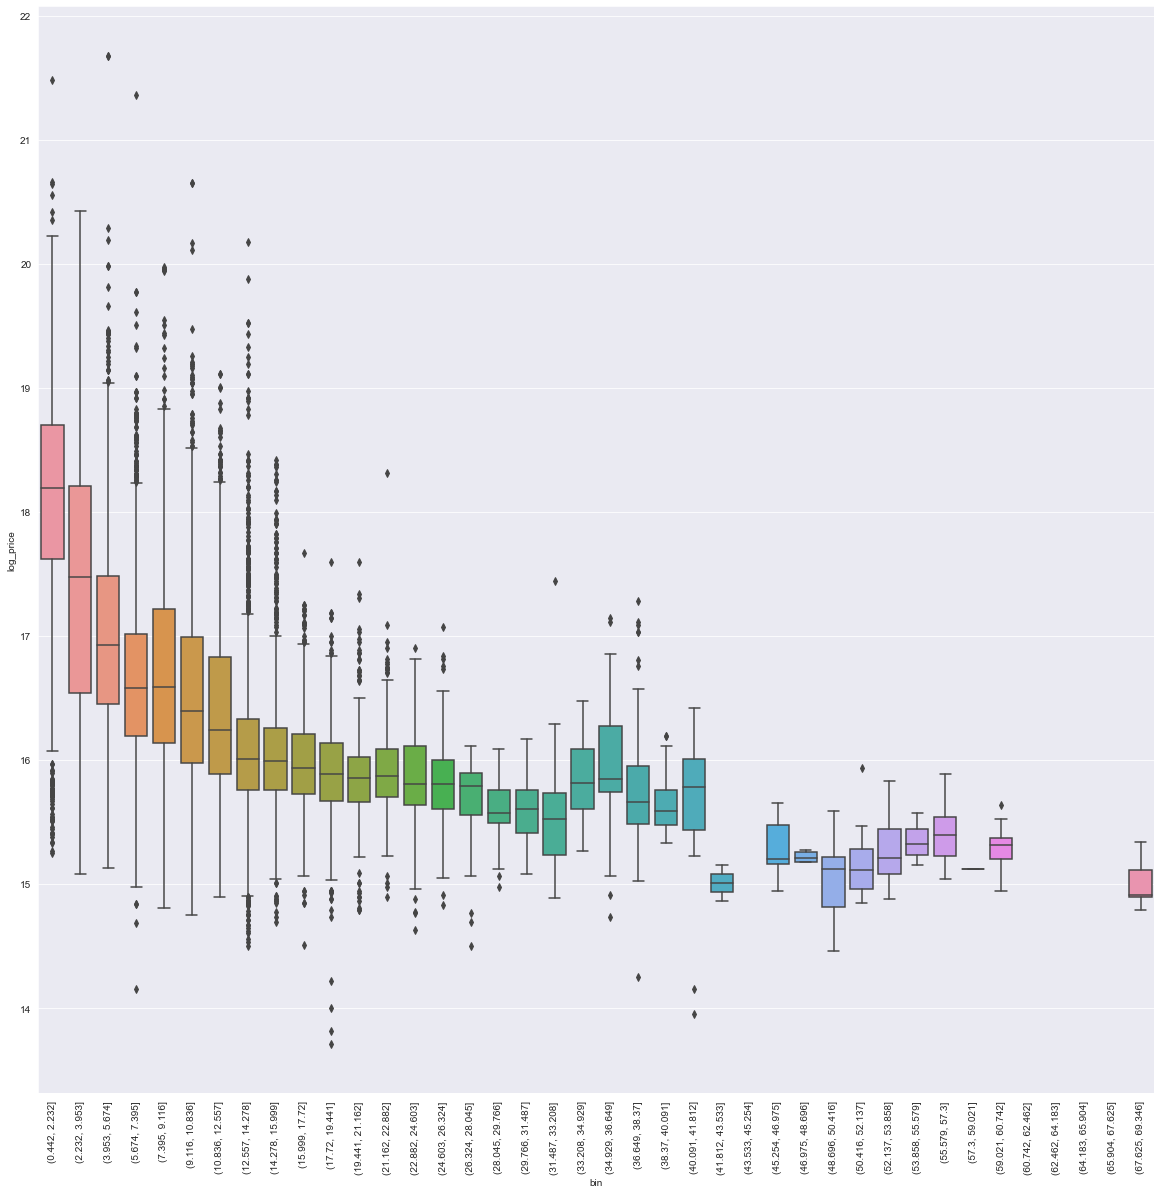

In [30]:
plt.figure(figsize=(20,20))
d = train
d["bin"], bins = pd.cut(d["distance_to_center"], bins=40, retbins=True)
ax = sns.boxplot(data=d, x="bin", y="log_price")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

**EDA insight:** The boxplot illustrates that there is a negative correlation between the log_price and the distance. However, there are several outliers in the bins with apartments closer to the city.

(<AxesSubplot:title={'center':'Moscow apartment log_price by location'}, xlabel='longitude', ylabel='latitude'>,
 <matplotlib.colors.Normalize at 0x12864f2e0>)

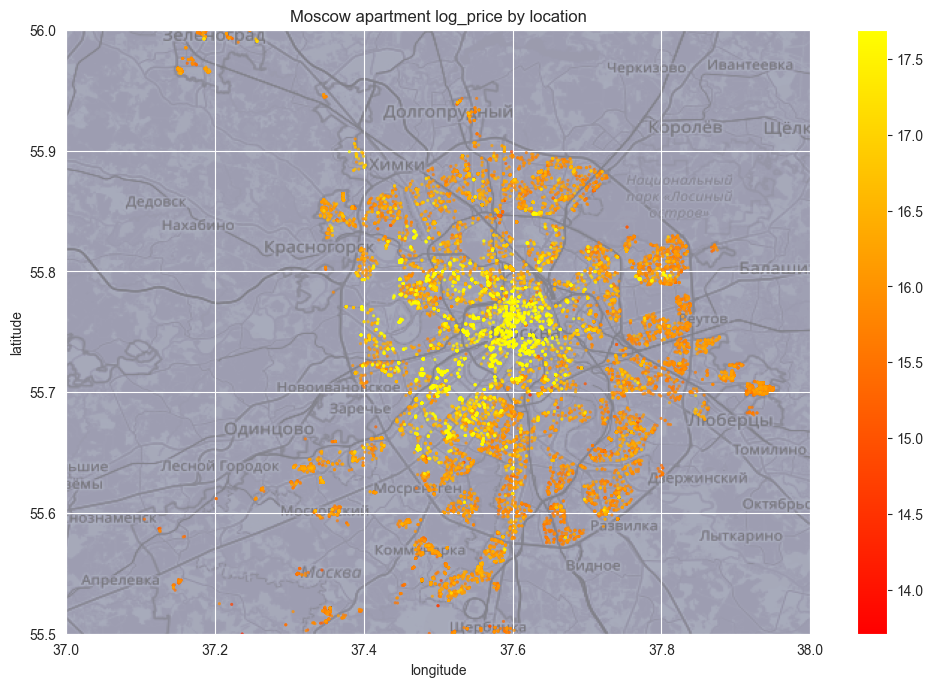

In [31]:
d = train
plot_map(data=d, column="log_price", title="Moscow apartment log_price by location")

**EDA insight:** Apartments that are in the center (0), west (7) and north-west (8) district have a greater log price variation than other districts. This difference can also be observed in the bearing (210 - 310) and direction (W - 6, NW - 7) plots and on the map plot.

0.6511642203709398


<AxesSubplot:xlabel='bathrooms', ylabel='log_price'>

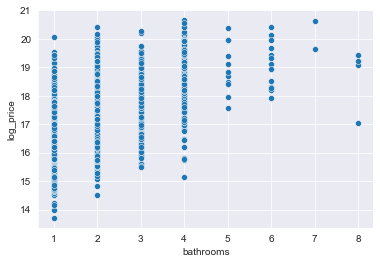

In [32]:
train["bathrooms"] = train.bathrooms_shared + train.bathrooms_private
d = train
print(d["bathrooms"].corr(d["log_price"]))
sns.scatterplot(x="bathrooms", y="log_price", data=d)

**EDA insight:** Number of bathrooms (shared or private) seem to have a positive effect on the log price.

In [33]:
print("Skewness in training data:")
skew_feats = train.skew().sort_values(ascending=False)
pd.DataFrame({'Skew': skew_feats}).T

Skewness in training data:


/var/folders/qj/3xgy61cn4896krzkbpyn7gth0000gn/T/ipykernel_6443/2914573080.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  skew_feats = train.skew().sort_values(ascending=False)


,ceiling,price,area_total,distance_to_metro,area_living,price_per_m2,heating,distance_to_hospital,floor,stories,area_kitchen,bathrooms,distance_to_center,log_price,bathrooms_shared,bathrooms_private,balconies,loggias,rooms,new,phones,layout,has_seller,elevator_without,district,condition,parking,windows_street,building_id,id,seller,longitude,bearing,latitude,material,elevator_service,constructed,windows_court,garbage_chute,elevator,elevator_passenger
Skew,26.90155,19.152175,8.610355,6.561202,5.319536,3.95057,3.824381,3.641513,2.790601,2.27116,2.207571,2.023348,1.738205,1.255021,0.990077,0.970663,0.934573,0.857511,0.804358,0.68645,0.590888,0.57412,0.497922,0.439809,0.308761,0.285369,0.228894,0.125547,0.022041,0.0,-0.268167,-0.29218,-0.297066,-0.450969,-0.514593,-1.112906,-1.476935,-1.478035,-1.551179,-3.040358,-3.36684


**EDA insight:** Some features have a high skewness, such as ceiling, price, area_total, etc. Skewness may cause issues and should be handled, i.e., by applying a log transformation.

## Feature Relations

### Correlation

<AxesSubplot:>

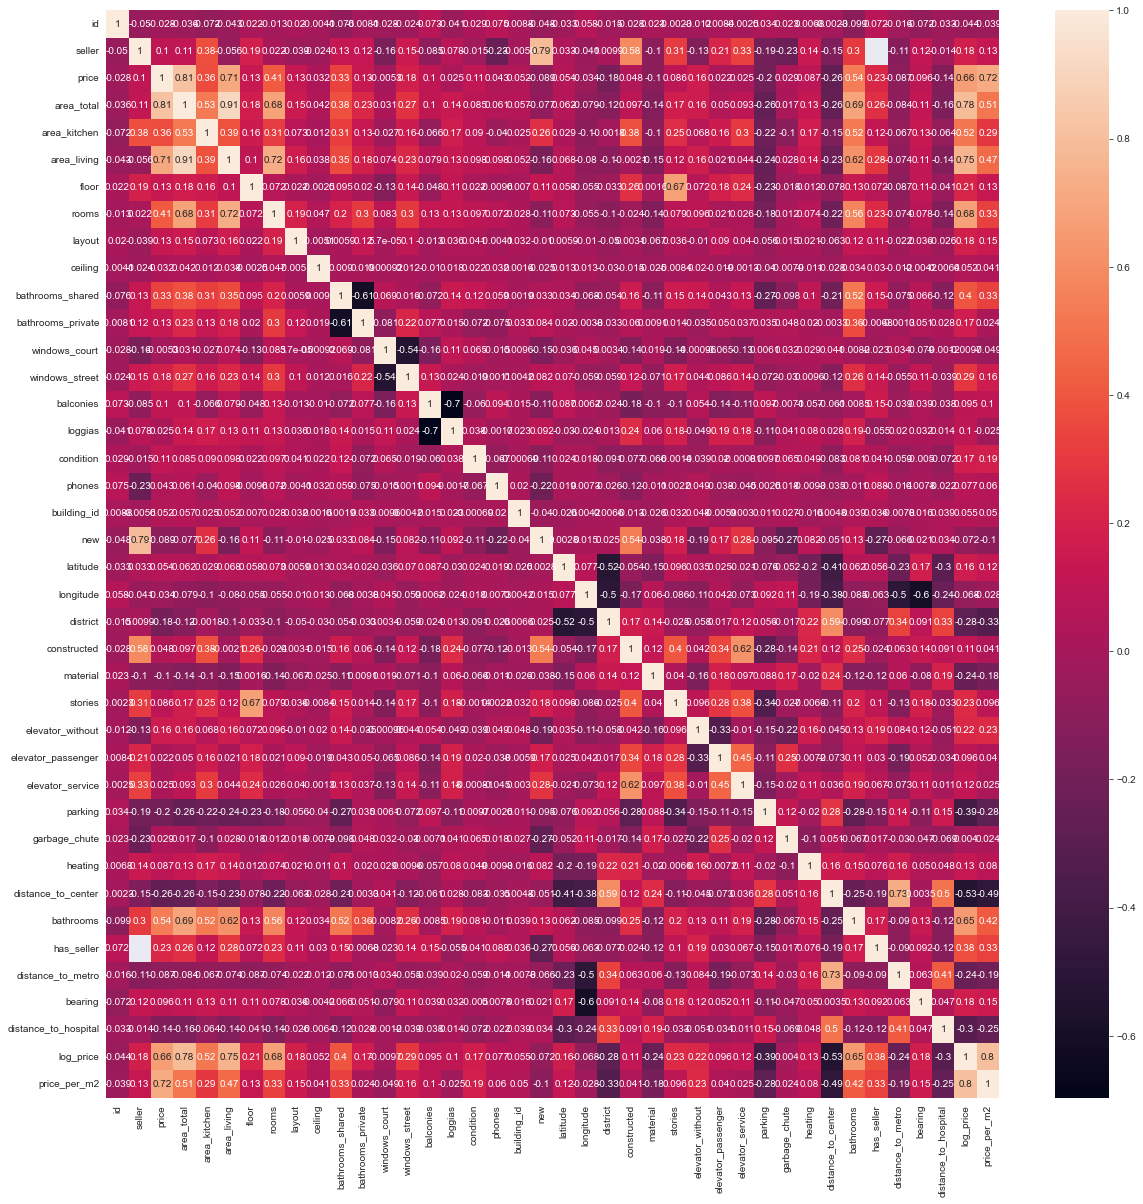

In [34]:
plt.figure(figsize=(20,20))
sns.heatmap(train.corr(), annot=True)

**EDA insight:** Correlation between the price and area_total, area_kitchen, area_living, floor, rooms, layout, bathrooms_shared, bathrooms_private, windows_street, balconies, district, material, elevator_without, and parking. However, some correlations may not be as strong as implied due the high number of missing values in some features, such as layout, balconies and condition.

In [35]:
print("Correlation between the price and the other features combined with the number of missing values:")
nan_count = [len(train[train[feature].isna()]) for feature in train.corr()["log_price"].index]
corr_df = pd.DataFrame(
    {
        "corr": train.corr()["log_price"], 
        "nan_count": nan_count,
        "nan_percentage": (np.array(nan_count) / train.shape[0])
    }
).sort_values(by="nan_count", ascending=False)
corr_df

Correlation between the price and the other features combined with the number of missing values:


,corr,nan_count,nan_percentage
layout,0.178670,17642,0.757655
ceiling,0.051916,11093,0.476401
loggias,0.104360,10520,0.451793
balconies,0.094621,10520,0.451793
condition,0.173769,9810,0.421301
seller,0.182874,8830,0.379214
garbage_chute,0.004026,8811,0.378398
heating,0.130949,8161,0.350483
windows_court,-0.009696,8072,0.346661
windows_street,0.289950,8072,0.346661


In [36]:
train.corr()
# drop area_living
# new correlates with seller
# constructed has high correlation with elevator_service, seller, area_kitchen, floor, 
# material should not be imputed based on constructed

,id,seller,price,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,bathrooms_shared,bathrooms_private,windows_court,windows_street,balconies,loggias,condition,phones,building_id,new,latitude,longitude,district,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating,distance_to_center,bathrooms,has_seller,distance_to_metro,bearing,distance_to_hospital,log_price,price_per_m2
id,1.000000,-0.050018,-0.027967,-0.036276,-0.072239,-0.043210,0.021645,-0.012996,0.019703,-0.004073,-0.075996,-0.008089,-0.027570,-0.023753,0.073007,-0.041497,0.028684,0.075082,0.008827,-0.047769,-0.032653,0.058294,-0.014863,-0.028175,0.022588,-0.002283,-0.012339,0.008354,-0.002497,0.033775,0.023121,0.006780,-0.002322,-0.098614,0.072391,-0.016061,-0.071977,-0.033476,-0.043946,-0.038921
seller,-0.050018,1.000000,0.101015,0.114745,0.376864,-0.055763,0.190066,0.022096,-0.039030,-0.023600,0.130936,0.122778,-0.161819,0.145882,-0.084547,0.077983,-0.014768,-0.234665,-0.005553,0.791454,0.032564,-0.040801,0.009875,0.583764,-0.103382,0.305980,-0.134120,0.213775,0.330314,-0.192977,-0.229963,0.142368,-0.148898,0.300523,NaN,-0.113508,0.115594,-0.014039,0.182874,0.130703
price,-0.027967,0.101015,1.000000,0.814829,0.364758,0.707580,0.132206,0.411317,0.130822,0.031640,0.332421,0.133364,-0.005345,0.180263,0.102928,0.024877,0.109338,0.042738,0.052159,-0.089292,0.054341,-0.034022,-0.183748,0.047633,-0.100614,0.086448,0.162024,0.021846,0.024681,-0.199476,0.029171,0.087359,-0.263489,0.537650,0.230983,-0.087435,0.096027,-0.144146,0.664611,0.718979
area_total,-0.036276,0.114745,0.814829,1.000000,0.529280,0.908815,0.177762,0.683526,0.147221,0.041942,0.378500,0.225475,0.030919,0.265340,0.103332,0.139916,0.085055,0.060927,0.057018,-0.076832,0.062404,-0.078859,-0.122858,0.096883,-0.138820,0.174020,0.164070,0.050413,0.092651,-0.259026,0.016534,0.130942,-0.257282,0.692050,0.262222,-0.083524,0.113099,-0.156934,0.782565,0.511141
area_kitchen,-0.072239,0.376864,0.364758,0.529280,1.000000,0.389498,0.157044,0.310664,0.073116,0.012147,0.313773,0.131383,-0.027259,0.158110,-0.065944,0.167754,0.090055,-0.039726,0.024592,0.260452,0.029257,-0.105000,-0.001833,0.382367,-0.102107,0.246464,0.068246,0.157797,0.299974,-0.218108,-0.103974,0.171449,-0.154584,0.524449,0.115587,-0.066549,0.134980,-0.064383,0.517461,0.289566
area_living,-0.043210,-0.055763,0.707580,0.908815,0.389498,1.000000,0.102976,0.723787,0.160304,0.037689,0.351467,0.180354,0.074356,0.226102,0.078505,0.134385,0.098331,0.097629,0.052115,-0.161924,0.068441,-0.079644,-0.103193,-0.002100,-0.146144,0.116837,0.160050,0.021064,0.044168,-0.241457,0.028150,0.138662,-0.228519,0.620543,0.284537,-0.074470,0.109503,-0.138082,0.749629,0.473497
floor,0.021645,0.190066,0.132206,0.177762,0.157044,0.102976,1.000000,0.072021,0.021685,-0.002535,0.095005,0.019962,-0.128585,0.136903,-0.047749,0.112012,0.021533,-0.009589,0.007016,0.114643,0.057541,-0.054793,-0.033161,0.260343,0.001599,0.673907,0.072166,0.179702,0.239427,-0.228434,-0.017805,0.011679,-0.078034,0.133966,0.071555,-0.087423,0.108685,-0.041099,0.212198,0.130058
rooms,-0.012996,0.022096,0.411317,0.683526,0.310664,0.723787,0.072021,1.000000,0.192759,0.047105,0.198755,0.302523,0.083395,0.296915,0.127831,0.128094,0.097378,0.072372,0.028493,-0.105370,0.072682,-0.054669,-0.103278,-0.023647,-0.142087,0.079107,0.096073,0.021288,0.025968,-0.184564,0.011870,0.074216,-0.218927,0.563152,0.234838,-0.073602,0.078136,-0.137499,0.678219,0.326585
layout,0.019703,-0.039030,0.130822,0.147221,0.073116,0.160304,0.021685,0.192759,1.000000,-0.005085,0.005949,0.121701,0.000057,0.103880,-0.012767,0.035874,0.041019,-0.004127,0.031815,-0.010459,0.005874,-0.010186,-0.050142,0.003140,-0.066952,0.036159,-0.010308,0.089920,0.040396,-0.056132,0.014581,0.021093,-0.063478,0.121637,0.106393,-0.021637,0.035847,-0.026245,0.178670,0.146888
ceiling,-0.004073,-0.023600,0.031640,0.041942,0.012147,0.037689,-0.002535,0.047105,-0.005085,1.000000,0.009018,0.019140,0.000920,0

# Data Cleaning

##  Drop features with very high percentage of nans and low correlation

In [37]:
nan_threshold = 0.3
rel_feats = corr_df[(corr_df.nan_percentage <= nan_threshold) & (corr_df["corr"].abs() > 0.1)]
rel_feats.sort_values(by="corr", ascending=False)

,corr,nan_count,nan_percentage
log_price,1.000000,0,0.000000
price_per_m2,0.801305,0,0.000000
area_total,0.782565,0,0.000000
area_living,0.749629,3882,0.166717
rooms,0.678219,0,0.000000
price,0.664611,0,0.000000
bathrooms,0.651164,3872,0.166287
area_kitchen,0.517461,4721,0.202749
bathrooms_shared,0.396012,3872,0.166287
has_seller,0.375276,0,0.000000


## Impute Missing Values

In [38]:
def impute_with_bin_mean(data, feature, bin_feature, bins=40, decimals=0, verbose=False): 
    tr = train.copy()
    te = test.copy()
    database = pd.concat([tr, te])
    database["bin"], bins = pd.cut(database[bin_feature], bins=40, retbins=True)
    pb = 0
    for b in bins:
        bin_data = database[(database[bin_feature] >= pb) & (database[bin_feature] <= b)]
        bin_mean = bin_data[feature].mean()
        percentage = (bin_mean / bin_data[bin_feature]).mean()
        d = data[(data[bin_feature] >= pb) & (data[bin_feature] <= b)]
        ind = d[d[feature].isna()].index
        if pd.notna(bin_mean) and len(ind) > 0:
            bin_mean = round(bin_mean, decimals)
            data.at[ind, feature] = bin_mean
            if verbose:
                print("Set {} for {} rows with {} <= area_living <= {} to {}".format(feature, len(ind), pb, b, bin_mean))
        pb = b

In [39]:
def impute_nearest_neighbour_mean(data, database, feature, k, nn_features, decimals=0):
    kd_tree = KDTree(database[nn_features])  
    d = data[data[feature].isna()]
    for ind, row in d.iterrows():
        neighbours = kd_tree.query([row[nn_features]], k=k, return_distance=False)[0]
        neighbour_mean = database.loc[neighbours][feature].mean()
        if not pd.isna(neighbour_mean):
            data.at[ind, feature] = round(neighbour_mean, decimals)

In [40]:
from sklearn.preprocessing import MinMaxScaler
def normalise_features(data, features, feature_prefix):
    d = data.copy()
    scaler = MinMaxScaler()
    for feature in features:
        norm_values = (d[feature] - np.mean(d[feature])) / np.std(d[feature])
        d["{}_{}".format(feature_prefix, feature)] = norm_values
    return d

In [41]:
train_test_combined = pd.concat([train, test], ignore_index=True)

### area_living

In [42]:
train_test_combined.corr().area_living

id                     -0.016382
seller                 -0.054688
price                   0.707580
area_total              0.908238
area_kitchen            0.390412
area_living             1.000000
floor                   0.094875
rooms                   0.724326
layout                  0.151520
ceiling                 0.034422
bathrooms_shared        0.349816
bathrooms_private       0.188046
windows_court           0.074643
windows_street          0.214452
balconies               0.080110
loggias                 0.147852
condition               0.089282
phones                  0.103567
building_id             0.030003
new                    -0.160674
latitude                0.020270
longitude               0.003921
district               -0.100103
constructed            -0.018279
material               -0.142003
stories                 0.098866
elevator_without        0.154498
elevator_passenger      0.016913
elevator_service        0.043219
parking                -0.219657
garbage_ch

area_living has a high correlation with area_total. Hence, it can be imputed using area_total. To do this, area_total is split into several features and area_living is imputed based on the average for each corresponding bin.

In [43]:
def impute_area_living(data):
    feature = "area_living"
    impute_with_bin_mean(data=data, feature=feature, bin_feature="area_total")
    d = data[data.area_living.isna()]
    for ind, row in d.iterrows():
        data.at[ind, feature] = 0.85 * row.area_total
    print("Remaining nan values for {}: {}".format(feature, len(data[data[feature].isna()])))
    return data

### area_kitchen

In [44]:
train_test_combined.corr().area_kitchen

id                     -0.020905
seller                  0.382460
price                   0.364758
area_total              0.525835
area_kitchen            1.000000
area_living             0.390412
floor                   0.165771
rooms                   0.316543
layout                  0.069211
ceiling                 0.012117
bathrooms_shared        0.312293
bathrooms_private       0.130256
windows_court          -0.023496
windows_street          0.157421
balconies              -0.074434
loggias                 0.178316
condition               0.073151
phones                 -0.035414
building_id             0.005901
new                     0.263295
latitude                0.018777
longitude              -0.000276
district               -0.011598
constructed             0.380721
material               -0.104652
stories                 0.255480
elevator_without        0.075488
elevator_passenger      0.156485
elevator_service        0.303741
parking                -0.208266
garbage_ch

For area_kitchen, the image is not as clear as with area_living. It has a high correlation with area_total and bathrooms and a moderate correlation with area_living, constructed, and rooms. It could either be imputed similar to area_living or by using the nearest neighbour method based on a set of features with the highest correlation. For now, it will also be imputed using bins over area_total.

In [45]:
def impute_area_kitchen(data):
    feature = "area_kitchen"
    impute_with_bin_mean(data=data, feature=feature, bin_feature="area_total")
    d = data[data.area_kitchen.isna()]
    for ind, row in d.iterrows():
        data.at[ind, feature] = 0.05 * row.area_total
    print("Remaining nan values for {}: {}".format(feature, len(data[data[feature].isna()])))
    return data

### bathrooms

In [46]:
train_test_combined.corr().bathrooms

id                     -0.057711
seller                  0.268043
price                   0.537650
area_total              0.698424
area_kitchen            0.525608
area_living             0.630761
floor                   0.120722
rooms                   0.572197
layout                  0.113116
ceiling                 0.030247
bathrooms_shared        0.528270
bathrooms_private       0.344637
windows_court          -0.005751
windows_street          0.252228
balconies              -0.002728
loggias                 0.193112
condition               0.064191
phones                  0.004938
building_id             0.022528
new                     0.097351
latitude                0.020643
longitude              -0.002619
district               -0.099993
constructed             0.227972
material               -0.119226
stories                 0.171481
elevator_without        0.135720
elevator_passenger      0.098764
elevator_service        0.187956
parking                -0.236390
garbage_ch

Bathrooms has a high correlation with area_total. Hence, it will also be imputed using bins over area_total.

In [47]:
def impute_bathrooms(data):
    feature = "bathrooms"
    impute_with_bin_mean(data=data, feature=feature, bin_feature="area_total")
    ind = data[data.area_total <= 800].index
    data.at[ind, feature] = 5
    ind = data[data.area_total > 800].index
    data.at[ind, feature] = 6
    print("Remaining nan values for {}: {}".format(feature, len(data[data[feature].isna()])))
    return data

### constructed

In [48]:
building_test_train_combined = pd.concat([buildings_train, buildings_test], ignore_index=True)

In [49]:
building_test_train_combined[building_test_train_combined.new == 0].corr().constructed

id                   -0.011770
new                        NaN
latitude             -0.108195
longitude            -0.020542
district              0.334695
constructed           1.000000
material              0.304097
stories               0.548448
elevator_without     -0.087555
elevator_passenger    0.265088
elevator_service      0.540592
parking              -0.337194
garbage_chute         0.093051
heating               0.225149
Name: constructed, dtype: float64

If the apartment is marked as new, constructed can simply be set to 2021. Hence, in the analysis above, only apartments that are not new are considered in order to find a feature that can be used to impute nan values.

There is a high correlation with stories and elevator_service. Since stories doesn't contain any nans, it would probably be best to base the imputation on stories alone using either bins or the nearest neighbour approach.

In [50]:
def impute_constructed(data):
    d = data[data.constructed.isna()]
    ind = d[d.new == 1].index
    data.at[ind, "constructed"] = 2021
    # impute_with_bin_mean(data=data, feature="constructed", bin_feature="stories", bins=12)
    database = normalise_features(building_test_train_combined, ["stories"], "norm")
    data = normalise_features(data, ["stories"], "norm")
    
    impute_nearest_neighbour_mean(
        data=data, 
        database=database,  
        feature="constructed", 
        k=50, 
        nn_features=["norm_stories"]
    )
    print("Remaining nan values for {}: {}".format("constructed", len(data[data["constructed"].isna()])))
    return data

### parking

In [51]:
building_test_train_combined = pd.concat([buildings_test, buildings_train], ignore_index=True)

In [52]:
building_test_train_combined.corr().parking

id                   -0.016015
new                  -0.196585
latitude             -0.050023
longitude             0.017528
district              0.031538
constructed          -0.357307
material              0.086716
stories              -0.280780
elevator_without     -0.067393
elevator_passenger   -0.095088
elevator_service     -0.236871
parking               1.000000
garbage_chute         0.151727
heating              -0.136496
Name: parking, dtype: float64

There are no features that have a high correlation with parking. There is only a medium correlation with constructed and a low correlation with stories. A nearest neighbour approach based on the these two features would probably be best. However, constructed has to be imputed first as it contains some nan values.

In [53]:
def impute_parking(data): 
    feature = "parking"
    data = normalise_features(data, ["stories", "constructed"], "norm")
    
    impute_nearest_neighbour_mean(
        data=data, 
        database=data,  
        feature="parking", 
        k=50, 
        nn_features=["norm_stories", "norm_constructed"]
    )
    ind = data[data.parking.isna()].index
    data.at[ind, feature] = 0
    print("Remaining nan values for {}: {}".format(feature, len(data[data[feature].isna()])))
    return data

### elevator_without

In [54]:
building_test_train_combined.corr().elevator_without

id                    0.007738
new                  -0.038138
latitude             -0.007721
longitude            -0.014086
district             -0.015867
constructed          -0.092987
material             -0.214658
stories              -0.239224
elevator_without      1.000000
elevator_passenger   -0.705795
elevator_service     -0.215513
parking              -0.067393
garbage_chute        -0.407649
heating               0.097805
Name: elevator_without, dtype: float64

In [55]:
def impute_elevator_without(data):
    feature = "elevator_without"
    impute_with_bin_mean(data=data, feature=feature, bin_feature="stories", bins=20)
    print("Remaining nan values for {}: {}".format(feature, len(data[data[feature].isna()])))
    return data

### material

In [56]:
building_test_train_combined.corr().material

id                    0.003500
new                  -0.014487
latitude             -0.038586
longitude            -0.003249
district              0.173575
constructed           0.283220
material              1.000000
stories               0.236548
elevator_without     -0.214658
elevator_passenger    0.250762
elevator_service      0.168714
parking               0.086716
garbage_chute         0.244531
heating              -0.001639
Name: material, dtype: float64

There is no decicive feature that can be used to impute material. A nearest neighbour approach should be used based on constructed, stories, and district.

In [57]:
def impute_material(data):
    feature = "material"
    
    data = normalise_features(data, ["stories", "constructed"], "norm")
    
    impute_nearest_neighbour_mean(
        data=data, 
        database=data,  
        feature="material", 
        k=150, 
        nn_features=["norm_stories", "norm_constructed", "district"]
    )
    
    print("Remaining nan values for {}: {}".format(feature, len(data[data[feature].isna()])))
    return data

### heating

In [58]:
building_test_train_combined.corr().heating

id                   -0.015233
new                   0.049554
latitude             -0.142173
longitude            -0.218225
district              0.188958
constructed           0.227024
material             -0.001639
stories               0.039193
elevator_without      0.097805
elevator_passenger   -0.040474
elevator_service      0.075791
parking              -0.136496
garbage_chute        -0.099582
heating               1.000000
Name: heating, dtype: float64

Same as with material, a nearest neighbour approach based on district and constructed would probably produce the best results. 

In [59]:
def impute_heating(data):
    feature = "heating"
    data = normalise_features(data, ["constructed"], "norm")
    
    impute_nearest_neighbour_mean(
        data=data, 
        database=data,  
        feature=feature, 
        k=350, 
        nn_features=["norm_constructed", "district"]
    )
    print("Remaining nan values for {}: {}".format(feature, len(data[data[feature].isna()])))

In [60]:
def impute_data(d):
    d = impute_area_living(d)
    d = impute_area_kitchen(d)
    d = impute_bathrooms(d)
    d = impute_constructed(d)
    d = impute_parking(d)
    d = impute_elevator_without(d)
    d = impute_material(d)
    # d = impute_heating(d)
    return d

In [61]:
print("Imputing training data...")
train_imputed = train.copy()
train_imputed = impute_data(train_imputed)

Imputing training data...
Remaining nan values for area_living: 0
Remaining nan values for area_kitchen: 0
Remaining nan values for bathrooms: 0
Remaining nan values for constructed: 0
Remaining nan values for parking: 0
Remaining nan values for elevator_without: 0
Remaining nan values for material: 0


In [62]:
print("Imputing test data...")
test_imputed = test.copy()
test_imputed = impute_data(test_imputed)

Imputing test data...
Remaining nan values for area_living: 0
Remaining nan values for area_kitchen: 0
Remaining nan values for bathrooms: 0
Remaining nan values for constructed: 0
Remaining nan values for parking: 0
Remaining nan values for elevator_without: 0
Remaining nan values for material: 0


## One-Hot Encoding of categorical features

In [63]:
district_names = {
    3: "East",
    6: "South-West",
    5: "South",
    4: "South-East",
    0: "Central",
    2: "North-East",
    1: "North",
    8: "North-West",
    7: "West",
    11: "Novomoskovsk",
    10: "Troitsk",
    9: "Zelenograd",
    12: "Other"
}
train_imputed = one_hot_encode(train_imputed, district_names, "district")
test_imputed = one_hot_encode(test_imputed, district_names, "district")

In [64]:
mat = {
    0: "Bricks",
    1: "Wood",
    2: "Monolith",
    3: "Panel",
    4: "Block",
    5: "Monolithic_brick",
    6: "Stalin_project",
}
train_imputed = one_hot_encode(train_imputed, mat, "material")
test_imputed = one_hot_encode(test_imputed, mat, "material")

In [65]:
heating = {
    0: "Central",
    1: "Individual",
    2: "Boiler",
    3: "Autonomous_boiler",
}

#train_imputed = one_hot_encode(train_imputed, heating, "heating")
#test_imputed = one_hot_encode(test_imputed, heating, "heating")

In [66]:
parking = {
    0: "Ground",
    1: "Underground",
    2: "Multilevel",
}

train_imputed = one_hot_encode(train_imputed, parking, "parking")
test_imputed = one_hot_encode(test_imputed, parking, "parking")

In [67]:
print("Correlation between the price and the other features combined with the number of missing values:")
nan_count = [len(train_imputed[train_imputed[feature].isna()]) for feature in train_imputed.corr()["log_price"].index]
corr_df = pd.DataFrame(
    {
        "corr": train_imputed.corr()["log_price"], 
        "nan_count": nan_count,
        "nan_percentage": (np.array(nan_count) / train_imputed.shape[0])
    }
).sort_values(by="nan_count", ascending=False)
nan_threshold = 0
corr_threshold = 0
rel_feats = corr_df[(corr_df.nan_percentage <= nan_threshold) & (corr_df["corr"].abs() >= corr_threshold)]
rel_feats.sort_values(by="corr", ascending=False)

Correlation between the price and the other features combined with the number of missing values:


,corr,nan_count,nan_percentage
log_price,1.000000,0,0.0
price_per_m2,0.801305,0,0.0
area_total,0.782565,0,0.0
area_living,0.694512,0,0.0
rooms,0.678219,0,0.0
price,0.664611,0,0.0
area_kitchen,0.579691,0,0.0
Central,0.501936,0,0.0
Ground,0.458225,0,0.0
has_seller,0.375276,0,0.0


In [68]:
features = rel_feats.index
features = features.drop(
     [
         "price", 
         "log_price", 
         "price_per_m2", 
         "district",  
         # "heating",
         "id",
         "building_id",
         "norm_constructed",
         "norm_stories"
     ]
 )
features

Index(['West', 'North', 'North-East', 'Central', 'South-East', 'South',
       'North-West', 'South-West', 'Wood', 'Novomoskovsk', 'Troitsk',
       'Zelenograd', 'Other', 'Bricks', 'Monolith', 'Panel', 'Block',
       'Monolithic_brick', 'Stalin_project', 'Ground', 'Underground', 'East',
       'distance_to_center', 'area_total', 'area_kitchen', 'area_living',
       'floor', 'rooms', 'latitude', 'longitude', 'constructed', 'material',
       'stories', 'elevator_without', 'parking', 'bathrooms', 'has_seller',
       'distance_to_metro', 'bearing', 'distance_to_hospital', 'Multilevel'],
      dtype='object')

# Outliers
First, the basic idea is to drop any rows that have greater values than in the testset as they will not help in predicting the price based on the selected features.

In [69]:
t = train_imputed.copy()
test_feat_min_max = pd.DataFrame({"max": test_imputed.describe().loc["max"], "min": test_imputed.describe().loc["min"]}).T
for feature in features:
    max_val = test_feat_min_max[feature]["max"]
    min_val = test_feat_min_max[feature]["min"]
    max_ind = t[t[feature] > max_val].index
    min_ind = t[t[feature] < min_val].index
    t.drop(max_ind, inplace=True)
    t.drop(min_ind, inplace=True)

print("Samples before: {} | Samples after: {}".format(len(train_imputed), len(t)))
train_imputed = t

Samples before: 23285 | Samples after: 23128


## Outlier analysis with of the features with respect to the price
### area_total

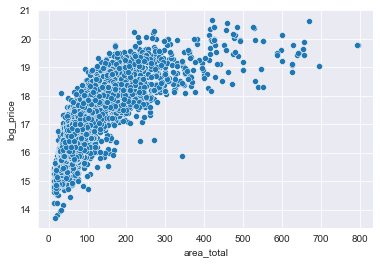

In [70]:
sns.scatterplot(data=train_imputed, x="area_total", y="log_price")
plt.show()

Some obvious outliers exist with respect to area_total.

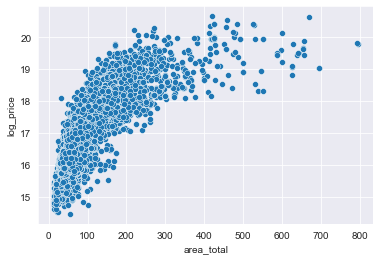

In [71]:
t = train_imputed.copy()
ind = t[(t.area_total > 200) & (t.area_total < 400) & (t.log_price < 17)].index
t.drop(ind, inplace=True)
ind = t[(t.area_total < 50) & (t.log_price < 14.5)].index
t.drop(ind, inplace=True)
sns.scatterplot(data=t, x="area_total", y="log_price")
plt.show()

## distance_to_center

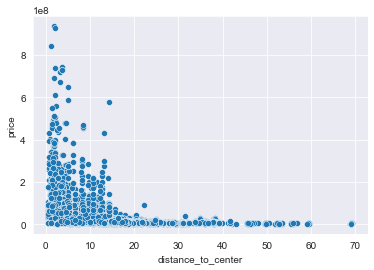

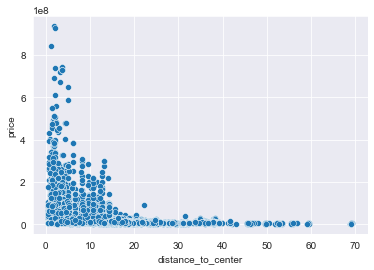

In [72]:
sns.scatterplot(data=t, x="distance_to_center", y="price")
plt.show()
ind = t[(t.distance_to_center > 10) & (t.distance_to_center < 20) & (t.price > 4e8)].index
t.drop(ind, inplace=True)
ind = t[(t.distance_to_center > 8) & (t.distance_to_center < 10) & (t.price > 4e8)].index
t.drop(ind, inplace=True)
sns.scatterplot(data=t, x="distance_to_center", y="price")
plt.show()

# Training and Model Optimisation

### Generating a val set close to testset

**IDEA:** Select n samples from the testset (according to the split-ratio), find the closest datapoint in the training set based on a set of features (i.e., area_total, distance, etc.), and add it to the validation set. Definitely include max and min values.

In [78]:
from sklearn.neighbors import KDTree
from tqdm import tqdm

def train_val_split(train_data, test_data, ratio=0.2):
    d_train = train_data.copy()
    d_test = test_data.copy()
    
    val_sample_count = round(ratio * train_data.shape[0])
    d_train = normalise_features(data=d_train, features=["area_total", "latitude", "longitude", "floor", "rooms"], feature_prefix="norm")
    d_test = normalise_features(data=d_train, features=["area_total", "latitude", "longitude", "floor", "rooms"], feature_prefix="norm")
    features = ["norm_area_total", "norm_latitude", "norm_longitude", "norm_floor", "norm_rooms", "district"]
    test_samples = d_test.sample(n=val_sample_count)
    val_set = []
    for i, test_sample in tqdm(test_samples.iterrows(), total=val_sample_count):
        tree = KDTree(d_train[features])
        ind = tree.query([test_sample[features]], return_distance=False)[0][0]
        val_set.append(d_train.loc[ind])
        d_train.drop(index=ind, inplace=True)
        d_train.reset_index(drop=True, inplace=True)
    return d_train, pd.DataFrame(val_set).reset_index()

In [79]:
X_train, X_val = train_val_split(t, test_imputed)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4622/4622 [01:35<00:00, 48.46it/s]


In [320]:
data_train = train_imputed
for feat in features:
    feat_with_nans = 0
    if len(train_imputed[train_imputed[feat].isna()]) > 0:
        print("#nan in {}: {}".format(feat, len(train_imputed[train_imputed[feat].isna()])))
        feat_with_nans += 1
if feat_with_nans == 0:
    print("No nans detected!")

No nans detected!


In [321]:
# f = features.copy()
# f = f.drop(
#     [
#         "area_living",
#     ]
# )

In [81]:
f = [
    "area_total", 
    "distance_to_center", 
    "distance_to_metro",
    "stories",
    "Underground",
    "floor",
    "constructed",
    "distance_to_hospital",
    "bearing",
    "West",
    "rooms",
]

In [82]:
from sklearn.metrics import mean_squared_log_error

def root_mean_squared_log_error(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

Valid rmsle: 0.0570
Valid rmsle: 0.2210


Text(0, 0.5, 'Ground Truth')

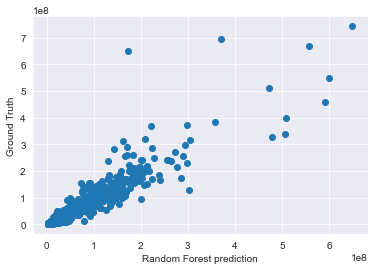

In [83]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(
    n_estimators=200,
    criterion='mse',
    n_jobs=2,
    random_state=42,
    max_features=7,
    min_samples_leaf=1,
)
rf_reg.fit(X_train[f], X_train["price_per_m2"])


rf_train_pred = rf_reg.predict(X_train[f])
rf_train_pred *= X_train.area_total
rf_rsmle = root_mean_squared_log_error(y_true=X_train["price"], y_pred=rf_train_pred)
print(f'Valid rmsle: {rf_rsmle :.4f}')

rf_val_pred = rf_reg.predict(X_val[f])
rf_val_pred *= X_val.area_total
rf_rsmle = root_mean_squared_log_error(y_true=X_val["price"], y_pred=rf_val_pred)
print(f'Valid rmsle: {rf_rsmle :.4f}')

plt.scatter(rf_val_pred, X_val["price"])
plt.xlabel('Random Forest prediction')
plt.ylabel('Ground Truth')

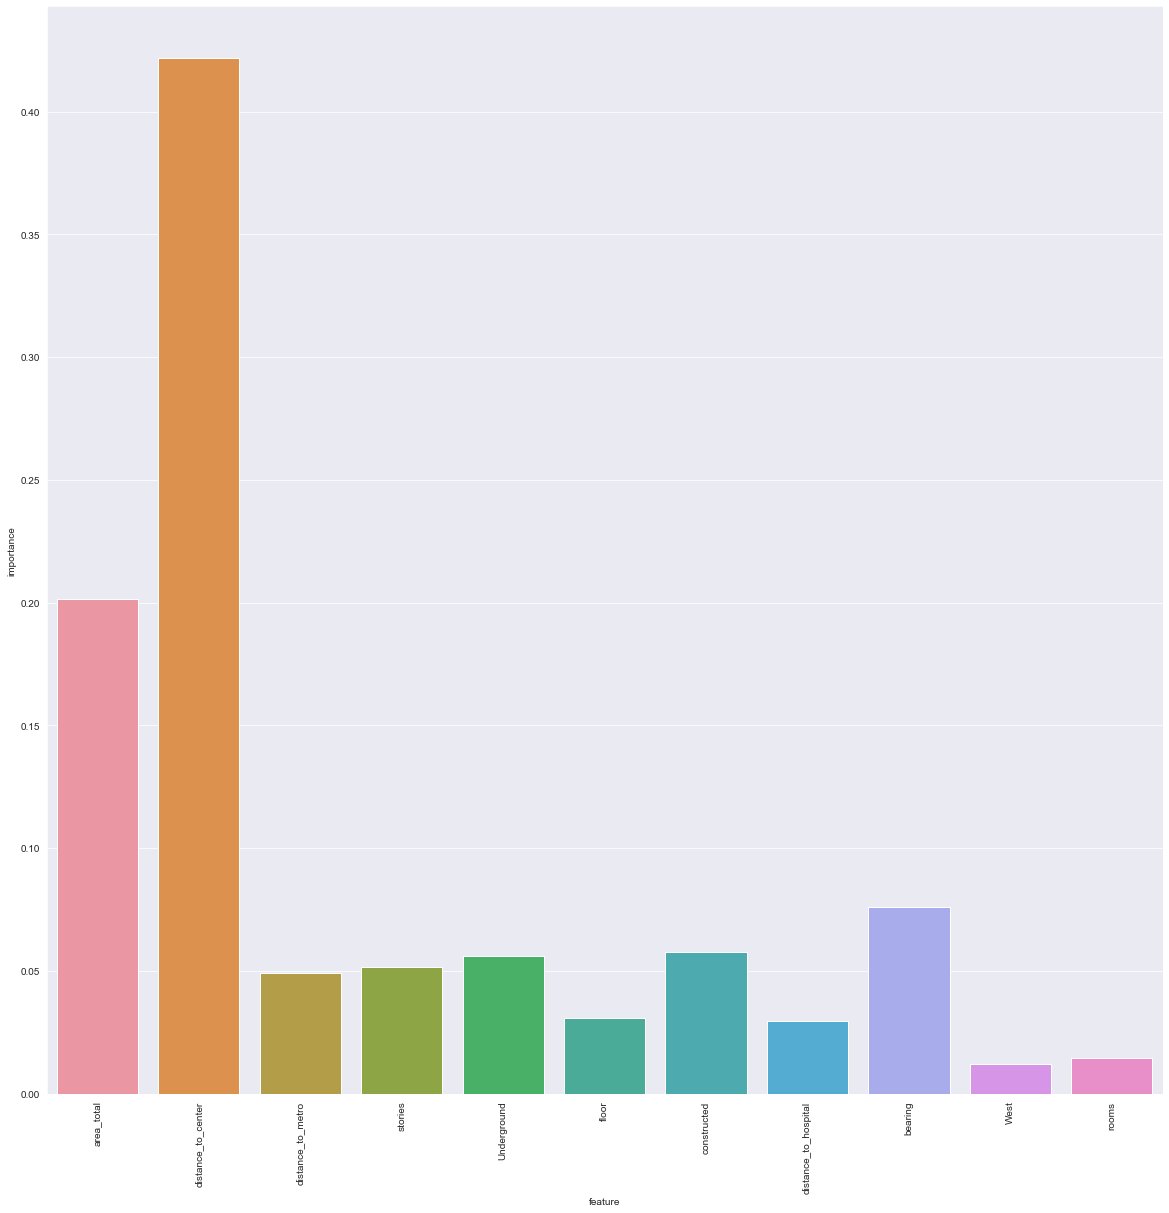

In [209]:
importances = pd.DataFrame({"importance": rf_reg.feature_importances_, "feature": f})
plt.figure(figsize=(20, 20))
ax = sns.barplot(data=importances, x="feature", y="importance")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

Train rmsle: 0.0307
Valid rmsle: 0.2008


Text(0, 0.5, 'Ground Truth')

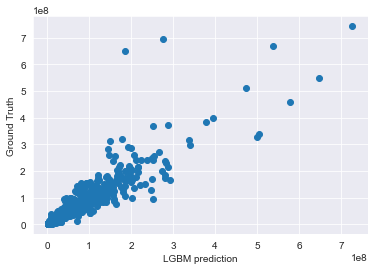

In [84]:
import lightgbm as lgbm

lgbm_reg = lgbm.LGBMRegressor(
    random_state=42,
    learning_rate=0.1,
    n_estimators=2000,
    boosting_type='gbdt',
    n_jobs=2,
    num_leaves=37
)

lgbm_reg.fit(X_train[f], X_train["price_per_m2"])

train_pred = lgbm_reg.predict(X_train[f])
# train_pred = (np.e ** train_pred)) - 1
train_pred *= X_train.area_total
train_rsmle = root_mean_squared_log_error(y_true=X_train["price"], y_pred=train_pred)
print(f'Train rmsle: {train_rsmle :.4f}')

lgbm_pred = lgbm_reg.predict(X_val[f])
# lgbm_pred = (np.e ** lgbm_pred) - 1
lgbm_pred *= X_val.area_total
lgbm_rsmle = root_mean_squared_log_error(y_true=X_val["price"], y_pred=lgbm_pred)
print(f'Valid rmsle: {lgbm_rsmle :.4f}')

plt.scatter(lgbm_pred, X_val["price"])
plt.xlabel('LGBM prediction')
plt.ylabel('Ground Truth')

In [228]:
from catboost import CatBoostRegressor
cb = CatBoostRegressor(
    n_estimators=2000,
    learning_rate=0.2,
    thread_count=-1,
    depth=7,
    silent=True,
    random_seed=42,
)

cb.fit(X_train[f], X_train["price_per_m2"])
cb_pred = cb.predict(X_val[f])
# cb_pred = (np.e ** cb_pred) - 1
cb_pred *= X_val.area_total
cb_rsmle = root_mean_squared_log_error(y_true=X_val["price"], y_pred=cb_pred)
print(f'Valid rmsle: {cb_rsmle :.4f}')

Valid rmsle: 0.1321


In [236]:
import xgboost as xgb

param = {
    'booster': 'gbtree'
}
num_round = 500

dtrain = xgb.DMatrix(X_train[f], label=X_train["price_per_m2"])
dval = xgb.DMatrix(X_val[f], label=X_val["price_per_m2"])

bst = xgb.train(param, dtrain, num_round)
xgb_pred = bst.predict(dval)
# xgb_pred = (np.e ** xgb_pred) - 1
xgb_pred *= X_val.area_total

xgb_rsmle = root_mean_squared_log_error(y_true=X_val["price"], y_pred=xgb_pred)
print(f'Valid rmsle: {xgb_rsmle :.4f}')

Valid rmsle: 0.1376


## Averaging

In [237]:
acc = pd.DataFrame({
    "rf": rf_rsmle,
    "lgbm": lgbm_rsmle,
    "cb": cb_rsmle,
    "xgb": xgb_rsmle,
}, index=[0])
acc = acc.T
acc.columns = ["rsmle"]
acc

,rsmle
rf,0.131183
lgbm,0.130268
cb,0.132066
xgb,0.137597


Valid rmsle: 0.1253


Text(0, 0.5, 'Ground Truth')

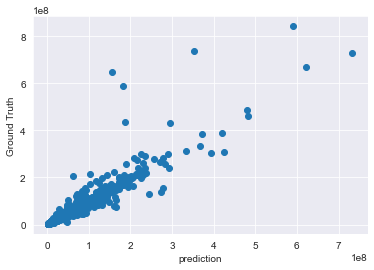

In [238]:
avg_prediction = np.average([rf_val_pred, lgbm_pred, cb_pred, xgb_pred], 
    weights = 1 / acc['rsmle'] ** 4,
    axis=0
)
# avg_prediction = np.mean([rf_val_pred, lgbm_pred, cb_pred, gbm_pred], axis=0)
print(f'Valid rmsle: {root_mean_squared_log_error(y_true=X_val["price"], y_pred=avg_prediction) :.4f}')
plt.scatter(avg_prediction, X_val["price"])
plt.xlabel('prediction')
plt.ylabel('Ground Truth')

# Prediction

In [239]:
data_test = test_imputed
for feat in f:  
    print("#nan in {}: {}".format(feat, len(data_test[data_test[feat].isna()])))

#nan in area_total: 0
#nan in distance_to_center: 0
#nan in distance_to_metro: 0
#nan in stories: 0
#nan in Underground: 0
#nan in floor: 0
#nan in constructed: 0
#nan in distance_to_hospital: 0
#nan in bearing: 0
#nan in West: 0
#nan in rooms: 0


In [240]:
rf_reg.fit(train_imputed[f], train_imputed["price_per_m2"])
lgbm_reg.fit(train_imputed[f], train_imputed["price_per_m2"])
cb.fit(train_imputed[f], train_imputed["price_per_m2"])
dtrain = xgb.DMatrix(train_imputed[f], label=train_imputed["price_per_m2"])
bst = xgb.train(param, dtrain, num_round)

In [241]:
X_test = data_test[f]

In [242]:

rf_pred = rf_reg.predict(X_test)
rf_pred *= X_test.area_total
lgbm_pred = lgbm_reg.predict(X_test)
# lgbm_pred = (np.e ** lgbm_pred) - 1
lgbm_pred *= X_test.area_total
cb_pred = cb.predict(X_test)
# cb_pred = (np.e ** cb_pred) - 1
cb_pred *= X_test.area_total
xgb_pred = bst.predict(xgb.DMatrix(X_test))
# xgb_pred = (np.e ** xgb_pred) - 1
xgb_pred *= X_test.area_total
pred = np.average([rf_pred, lgbm_pred, cb_pred, xgb_pred], 
    weights = 1 / acc['rsmle'] ** 4,
    axis=0
)

In [243]:
submission = pd.DataFrame()
submission['id'] = data_test.id
submission['price_prediction'] = pred
submission.to_csv('submission.csv', index=False)

print('\nLine count of submission')
!wc -l submission.csv

print('\nFirst 5 rows of submission')
!head -n 5 submission.csv


Line count of submission
    9938 submission.csv

First 5 rows of submission
id,price_prediction
23285,29564825.923569817
23286,8328462.730657494
23287,6155828.715110619
23288,9471376.59347767
